## Training Deep Neural Networks

Training a deep neural network is not as easy as just adding more and more layers. There are lot of things to consider.

* First, you would be faced with the tricky vanishing gradients problem (or the
related exploding gradients problem) that affects deep neural networks and makes
lower layers very hard to train.
* Second, you might not have enough training data for such a large network, or it
might be too costly to label.
* Third, training may be extremely slow.
* Fourth, a model with millions of parameters would severely risk overfitting the
training set, especially if there are not enough training instances, or they are too
noisy.

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

### Vanishing/Exploding Gradients Problems

The backpropagation algorithm works by going from
the output layer to the input layer, propagating the error gradient on the way. Once
the algorithm has computed the gradient of the cost function with regards to each
parameter in the network, it uses these gradients to update each parameter with a
Gradient Descent step.<br>
Unfortunately, gradients often get smaller and smaller as the algorithm progresses
down to the lower layers. As a result, the Gradient Descent update leaves the lower
layer connection weights virtually unchanged, and training never converges to a good
solution. This is called the vanishing gradients problem. In some cases, the opposite
can happen: the gradients can grow bigger and bigger, so many layers get insanely
large weight updates and the algorithm diverges. This is the exploding gradients problem, which is mostly encountered in recurrent neural networks.

This happens because a lot of reasons. A lot of research are still going on in this field. It was showed that the combination of the popular logistic sigmoid activation function and the
weight initialization technique that was most popular at the time, namely random initialization using a normal distribution with a mean of 0 and a standard deviation of 1 were two of main culprits. With this, the variance of the outputs of each layer is much greater than the variance of its
inputs. Going forward in the network, the variance keeps increasing after each layer
until the activation function saturates at the top layers. This is actually made worse by
the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent
function has a mean of 0 and behaves slightly better than the logistic function in deep
networks).

Looking at the logistic activation function, you can see that when
inputs become large (negative or positive), the function saturates at 0 or 1, with a
derivative extremely close to 0. Thus when backpropagation kicks in, it has virtually
no gradient to propagate back through the network, and what little gradient exists
keeps getting diluted as backpropagation progresses down through the top layers, so
there is really nothing left for the lower layers.

<figure>
<figcaption><h4>Logistic activation function saturation</h4></figcaption>
<img src = "img/11_01.png">
</figure>

#### Glorot and He Initialization

For backpropogation to work properly,we don't want the gradients to die out, nor do we want it to explode and saturate.
For the signal to flow properly, the it was proposed that we need the variance of the
outputs of each layer to be equal to the variance of its inputs, and we also need the
gradients to have equal variance before and after flowing through a layer in the
reverse direction. It is actually not possible to guarantee both unless the layer has an equal
number of inputs and neurons (these numbers are called the fan-in and fan-out of the
layer). The connection weights of each layer must be initialized randomly as described by:

<figure>
<figcaption><h4>Glorot initialization</h4></figcaption>
<img src = "img/11_02.png">
</figure>

Where:
$$ \text{fan}_{avg} = \frac{\text{fan}_{in} + \text{fan}_{out}}{2} $$

Replacing $\text{fan}_{in}$ with $\text{fan}_{avg}$ gives the usual random initialization.

Using Glorot initialization can speed up training considerably, and it is one of the tricks that led to the current success of Deep
Learning. Similar initialization are given for other activation functions.

<figure>
<figcaption><h4>Initialization parameters for each type of activation function</h4></figcaption>
<img src = "img/11_03.png">
</figure>

By default, Keras uses Glorot initialization with a uniform distribution. You can
change this to He initialization by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"` when creating a layer.

`keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")`

If you want He initialization with a uniform distribution, but based on $fan_{avg}$ rather
than $fan_{in}$, you can use the `VarianceScaling` initializer like this:<br>


In [84]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

#### Nonsaturating Activation Functions

Using activation function other than the logistic, like ReLU usually performs better in deep learning mostly because it does
not saturate for positive values (and also because it is quite fast to compute).<br>
Unfortunately, the ReLU activation function is not perfect. It suffers from a problem
known as the dying ReLUs: during training, some neurons effectively die, meaning
they stop outputting anything other than 0. In some cases, you may find that half of
your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the weighted sum of its
inputs are negative for all instances in the training set. When this happens, it just
keeps outputting 0s, and gradient descent does not affect it anymore since the gradient of the ReLU function is 0 when its input is negative.
To solve this problem, you may want to use a variant of the ReLU function, such as
the leaky ReLU. This function is defined as $\text{LeakyReLU}_{\alpha}(z) = max(\alpha z, z)$. The hyperparameter α defines how much the function “leaks”: it is the
slope of the function for z < 0, and is typically set to 0.01. This small slope ensures
that leaky ReLUs never die; they can go into a long coma, but they have a chance to
eventually wake up.

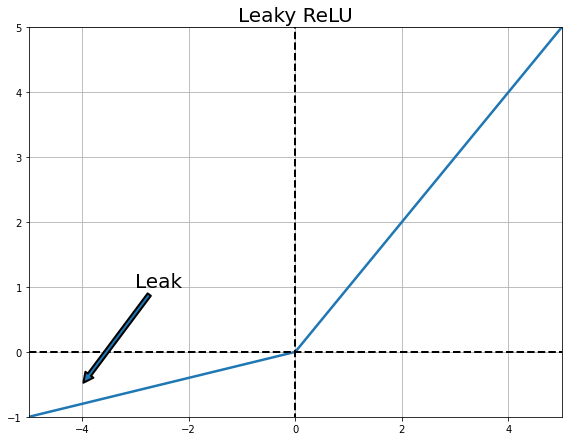

In [62]:
def leakyrelu(x, alpha=0.3):
    return np.maximum(x, alpha * x)

x = np.linspace(-5, 5, 200)
plt.figure(figsize=(8, 6))
plt.plot(x, leakyrelu(x, 0.2), linewidth = 2.5)
plt.plot(x, np.zeros(x.shape), 'k--', linewidth = 2)
plt.plot(np.zeros(x.shape), x, 'k--', linewidth = 2)
plt.annotate("Leak",
            xy=(-4, -0.5), xycoords='data',
            xytext=(-3, 1), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3", linewidth=2),
                            size=20)
plt.grid(True)    
plt.xlim(-5, 5)
plt.ylim(-1, 5)                      
plt.tight_layout()           
plt.title('Leaky ReLU', fontdict={'fontsize': 20});

In 2015, a new activation function called the exponential linear unit (ELU) that outperformed all the ReLU
variants in their experiments: training time was reduced and the neural network performed better on the test set.

$$
\text{ELU}=\begin{cases}
			\alpha(\exp{z}-1), & \text{if $z<0$}\\
            z, & \text{if $z\ge0$}
		 \end{cases}
$$

In [75]:
def ELU(z, alpha=0.3):
    if z<0:
        return alpha*( np.exp(z)-1)
    else:
        return  z
ELU = np.vectorize(ELU)

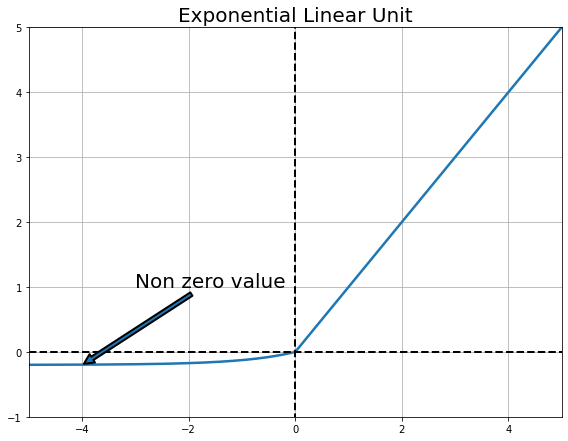

In [81]:
x = np.linspace(-5, 5, 200)
plt.figure(figsize=(8, 6))
plt.plot(x, ELU(x, 0.2), linewidth = 2.5)
plt.plot(x, np.zeros(x.shape), 'k--', linewidth = 2)
plt.plot(np.zeros(x.shape), x, 'k--', linewidth = 2)
plt.annotate("Non zero value",
            xy=(-4, -0.2), xycoords='data',
            xytext=(-3, 1), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3", linewidth=2),
                            size=20)
plt.grid(True)    
plt.xlim(-5, 5)
plt.ylim(-1, 5)                      
plt.tight_layout()           
plt.title('Exponential Linear Unit', fontdict={'fontsize': 20});

The main drawback of the ELU activation function is that it is slower to compute
than the ReLU and its variants (due to the use of the exponential function), but during training this is compensated by the faster convergence rate. However, at test time
an ELU network will be slower than a ReLU network.

In 2017 some researchers showed that if you build a neural network composed
exclusively of a stack of dense layers, and if all hidden layers use the SELU activation
function (which is just a scaled version of the ELU activation function, as its name
suggests), then the network will self-normalize: the output of each layer will tend to
preserve mean 0 and standard deviation 1 during training, which solves the vanishing/exploding gradients problem. 

>So which activation function should you use for the hidden layers
of your deep neural networks? Although your mileage will vary, in
general SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh
> logistic. If the network’s architecture prevents it from selfnormalizing, then ELU may perform better than SELU (since SELU
is not smooth at z = 0). If you care a lot about runtime latency, then
you may prefer leaky ReLU. 

To use the leaky ReLU activation function, you must create a `LeakyReLU` instance like
this:

In [85]:
leaky_relu = keras.layers.LeakyReLU(alpha=0.2)
layer = keras.layers.Dense(10, activation=leaky_relu,
kernel_initializer="he_normal")

For SELU activation, just set `activation="selu"` and `kernel_initializer="lecun_normal"` when creating a layer:

In [86]:
layer = keras.layers.Dense(10, activation="selu",
kernel_initializer="lecun_normal")

#### Batch Normalization

Another technique to solve the vanishing/exploding gradients problems is batch normalization. The technique consists of adding an operation in the model just before or after the
activation function of each hidden layer, simply zero-centering and normalizing each
input, then scaling and shifting the result using two new parameter vectors per layer:
one for scaling, the other for shifting. In other words, this operation lets the model
learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you
add a BN layer as the very first layer of your neural network, you do not need to
standardize your training set (e.g., using a `StandardScaler`): the BN layer will do it
for you (well, approximately, since it only looks at one batch at a time, and it can also
rescale and shift each input feature).

To sum up, four parameter vectors are learned in each batch-normalized
layer: $\mathbf{\gamma}$ (the ouput scale vector) and $\mathbf{\beta}$ (the output offset vector) are learned through
regular backpropagation, and $\mathbf{\mu}$ (the final input mean vector), and $\mathbf{\sigma}$ (the final input
standard deviation vector) are estimated using an exponential moving average. Note
that $\mathbf{\mu}$ and $\mathbf{\sigma}$ are estimated during training, but they are not used at all during training, only after training.

Using BN, generally results in better performance in every DNN. using BN the gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the tanh and even the logistic activation function. We are able to use much larger learning rates, significantly speeding up the learning process. What's more, Batch Normalization also acts like a regularizer, reducing the need for other regularization techniques. Batch Normalization does, however, add some complexity to the model (although it
can remove the need for normalizing the input data, as we discussed earlier). Moreover, there is a runtime penalty: the neural network makes slower predictions due to
the extra computations required at each layer.

>You may find that training is rather slow, because each epoch takes
much more time when you use batch normalization. However, this
is usually counterbalanced by the fact that convergence is much
faster with BN, so it will take fewer epochs to reach the same performance.

To use BN, just add a `BatchNormalization` layer before or after each hidden layer’s activation
function, and optionally add a BN layer as well as the first layer in your model.

In [93]:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]),
keras.layers.BatchNormalization(),
keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
keras.layers.BatchNormalization(),
keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
keras.layers.BatchNormalization(),
keras.layers.Dense(10, activation="softmax")
])

In [94]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 784)               3136      
_________________________________________________________________
dense_9 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_7 (Batch (None, 300)               1200      
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)               400       
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

From the model summary, you can see that each BN layer
adds 4 parameters per input: γ, β, μ and σ (for example, the first BN layer adds 3136
parameters, which is 4 times 784). The last two parameters, μ and σ, are the moving
averages, they are not affected by backpropagation, so Keras calls them “Nontrainable” (if you count the total number of BN parameters, 3136 + 1200 + 400, and
divide by two, you get 2,368, which is the total number of non-trainable params in
this model).<br>
Let’s look at the parameters of the first BN layer. Two are trainable (by backprop), and
two are not:

In [89]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after (as we just did). To add the BN layers before the activation functions, we must remove the activation function from the hidden layers, and
add them as separate layers after the BN layers. Moreover, since a Batch Normalization layer includes one offset parameter per input, you can remove the bias term from
the previous layer.

In [90]:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]),
keras.layers.BatchNormalization(),
keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
keras.layers.BatchNormalization(),
keras.layers.Activation("elu"),
keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
keras.layers.Activation("elu"),
keras.layers.BatchNormalization(),
keras.layers.Dense(10, activation="softmax")
])

The `BatchNormalization` class has quite a few hyperparameters you can tweak. The
defaults will usually be fine, but you may occasionally need to tweak the `momentum`. A good `momentum` value is typically close to 1—for example, 0.9, 0.99, or 0.999 (you
want more 9s for larger datasets and smaller mini-batches).

Another important hyperparameter is `axis`: it determines which axis should be normalized. It defaults to –1, meaning that by default it will normalize the last axis (using
the means and standard deviations computed across the other axes). For example,
when the input batch is 2D (i.e., the batch shape is [batch size, features]), this means
that each input feature will be normalized based on the mean and standard deviation
computed across all the instances in the batch. For example, the first BN layer in the
previous code example will independently normalize (and rescale and shift) each of
the 784 input features. However, if we move the first BN layer before the `Flatten` layer, then the input batches will be 3D, with shape [batch size, height, width], there‐
fore the BN layer will compute 28 means and 28 standard deviations (one per column
of pixels, computed across all instances in the batch, and all rows in the column), and
it will normalize all pixels in a given column using the same mean and standard deviation. There will also be just 28 scale parameters and 28 shift parameters. If instead
you still want to treat each of the 784 pixels independently, then you should set
axis=[1, 2].

>Batch Normalization has become one of the most used layers in deep neural networks, to the point that it is often omitted in the diagrams, as it is assumed that BN is
added after every layer.

#### Gradient Clipping

Another popular technique to lessen the exploding gradients problem is to simply
clip the gradients during backpropagation so that they never exceed some threshold. This is called gradient clipping. In Keras, implementing Gradient Clipping is just a matter of setting the `clipvalue` or
`clipnorm` argument when creating an optimizer. For example:

In [91]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

This will clip every component of the gradient vector to a value between –1.0 and 1.0.
This means that all the partial derivatives of the loss (with regards to each and every
trainable parameter) will be clipped between –1.0 and 1.0. The threshold is a hyperparameter you can tune. Note that it may change the orientation of the gradient vector. If you want to ensure that Gradient Clipping does not change
the direction of the gradient vector, you should clip by norm by setting `clipnorm`
instead of `clipvalue`. This will clip the whole gradient if its $ℓ_2$ norm is greater than
the threshold you picked.

### Reusing Pretrained Layers